In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, auc

%matplotlib inline

In [349]:
trainDf = pd.read_csv("./train_data.csv", encoding="utf-8")
testDf = pd.read_csv("./test_features.csv", encoding="utf-8")
trainDf.head()

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [350]:
print("訓練集形狀: ", trainDf.shape)
print("測試集形狀: ", testDf.shape)

訓練集形狀:  (113, 22)
測試集形狀:  (33, 21)


In [351]:

def featureFilter(data, typeString):
    
    if not isinstance(trainDf, pd.DataFrame):
        raise TypeError("Type of data must be DataFrame.")
    
    typeStringBox = ["float64", "object"]
    if not typeString in typeStringBox:
        raise ValueError("typeString must be float64 or object.")    
    
    
    feature_number = []
    for t, col in zip(data.dtypes, data.columns):
        if t == typeString:
            feature_number.append(col)

    return feature_number

feature_number_train = featureFilter(trainDf, "float64")
feature_number_test = featureFilter(testDf, "float64")

print(f'''
訓練集數值型特徵數量: {len(feature_number_train)}
看一下有哪些訓練集數值型特徵:\n{feature_number_train}
測試集數值型特徵數量: {len(feature_number_test)}
看一下有哪些測試集數值型特徵:\n{feature_number_test}
''')



訓練集數值型特徵數量: 19
看一下有哪些訓練集數值型特徵:
['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']
測試集數值型特徵數量: 19
看一下有哪些測試集數值型特徵:
['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']



In [352]:
featureNumDf = trainDf[feature_number_train]
featureNumDf.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [353]:

def featureNullRatio(data, ascending=False):

    if not isinstance(data, pd.DataFrame):
        raise TypeError("Type of data must be pd.DataFrame.")
    
    if not isinstance(ascending, bool):
        raise TypeError("Type of ascending must be bool.")

    ratio = data.isnull().sum() / data.shape[0]
    
    return ratio.sort_values(ascending=ascending)

ratio = featureNullRatio(trainDf[feature_number_train])
print("看一下訓練集缺失值占全體數據的比例:\n", ratio)
ratio = featureNullRatio(testDf[feature_number_test])
print("看一下測試集缺失值占全體數據的比例:\n", ratio)


看一下訓練集缺失值占全體數據的比例:
 loan_advances                0.982301
restricted_stock_deferred    0.911504
director_fees                0.884956
deferral_payments            0.752212
deferred_income              0.699115
long_term_incentive          0.566372
bonus                        0.460177
from_this_person_to_poi      0.424779
from_poi_to_this_person      0.424779
from_messages                0.424779
shared_receipt_with_poi      0.424779
to_messages                  0.424779
other                        0.389381
expenses                     0.353982
salary                       0.353982
exercised_stock_options      0.283186
restricted_stock             0.274336
total_payments               0.150442
total_stock_value            0.132743
dtype: float64
看一下測試集缺失值占全體數據的比例:
 loan_advances                0.939394
director_fees                0.878788
restricted_stock_deferred    0.757576
deferral_payments            0.666667
deferred_income              0.545455
long_term_incentive          0.48

========bonus========
count    6.100000e+01
mean     1.147436e+06
std      1.505189e+06
min      7.000000e+04
25%      4.500000e+05
50%      7.500000e+05
75%      1.000000e+06
max      8.000000e+06
Name: bonus, dtype: float64
========deferral_payments========
count    2.800000e+01
mean     6.344374e+05
std      8.603646e+05
min     -1.025000e+05
25%      7.656750e+04
50%      1.951900e+05
75%      8.342052e+05
max      2.964506e+06
Name: deferral_payments, dtype: float64
========deferred_income========
count    3.400000e+01
mean    -4.625664e+05
std      8.095392e+05
min     -3.504386e+06
25%     -5.527032e+05
50%     -1.175340e+05
75%     -2.708325e+04
max     -1.042000e+03
Name: deferred_income, dtype: float64
========director_fees========
count        13.000000
mean      89397.846154
std       41143.391399
min        3285.000000
25%      101250.000000
50%      108579.000000
75%      112492.000000
max      125034.000000
Name: director_fees, dtype: float64
========exercised_stock_opti

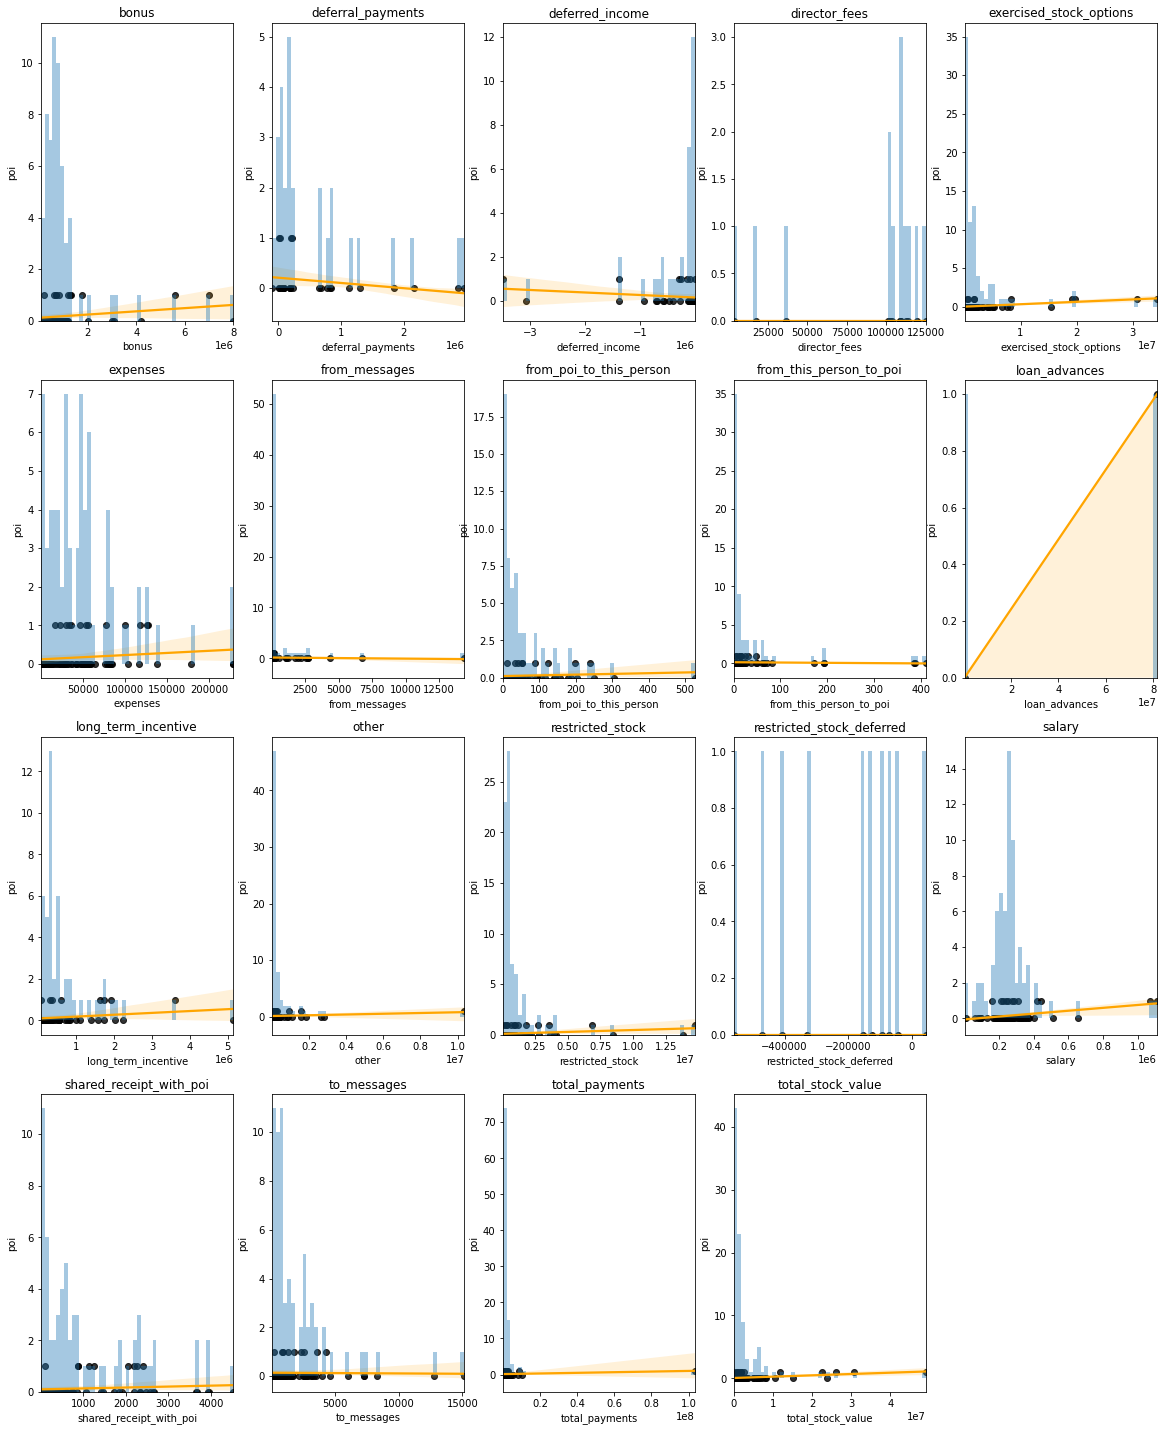

In [354]:

def eda(data, target=None, figsize=(20,150), ncol=5, describe=True):

    if not isinstance(data, pd.DataFrame):
        raise TypeError("Type of data must be pd.Series.")

    if not isinstance(target, pd.Series):
        raise TypeError("Type of data must be pd.Series.")
    
    if not isinstance(figsize, tuple):
        raise TypeError("Type of figsize must be tuple.")

    if not isinstance(ncol, int):
        raise TypeError("Type of ncol must be int.")
    
    if not isinstance(describe, bool):
        raise TypeError("Type of describe must be bool.")

    plt.figure(figsize=figsize)

    Sum = data.shape[0]
    ncol = ncol
    nrow = (Sum // ncol) + 1
    for idx, colName in enumerate(data): 
        if describe == True:
            print(f"========{colName}========")
            print(data[colName].describe())
        plt.subplot(nrow, ncol, idx+1)
        data[colName].describe()
        plt.title(colName)
        sns.distplot(data[colName], bins=50, kde=False)
        sns.regplot(data[colName], target, line_kws={"color":"orange"}, scatter_kws={"color":"black"})

    return 

eda(trainDf[feature_number_train], trainDf["poi"])

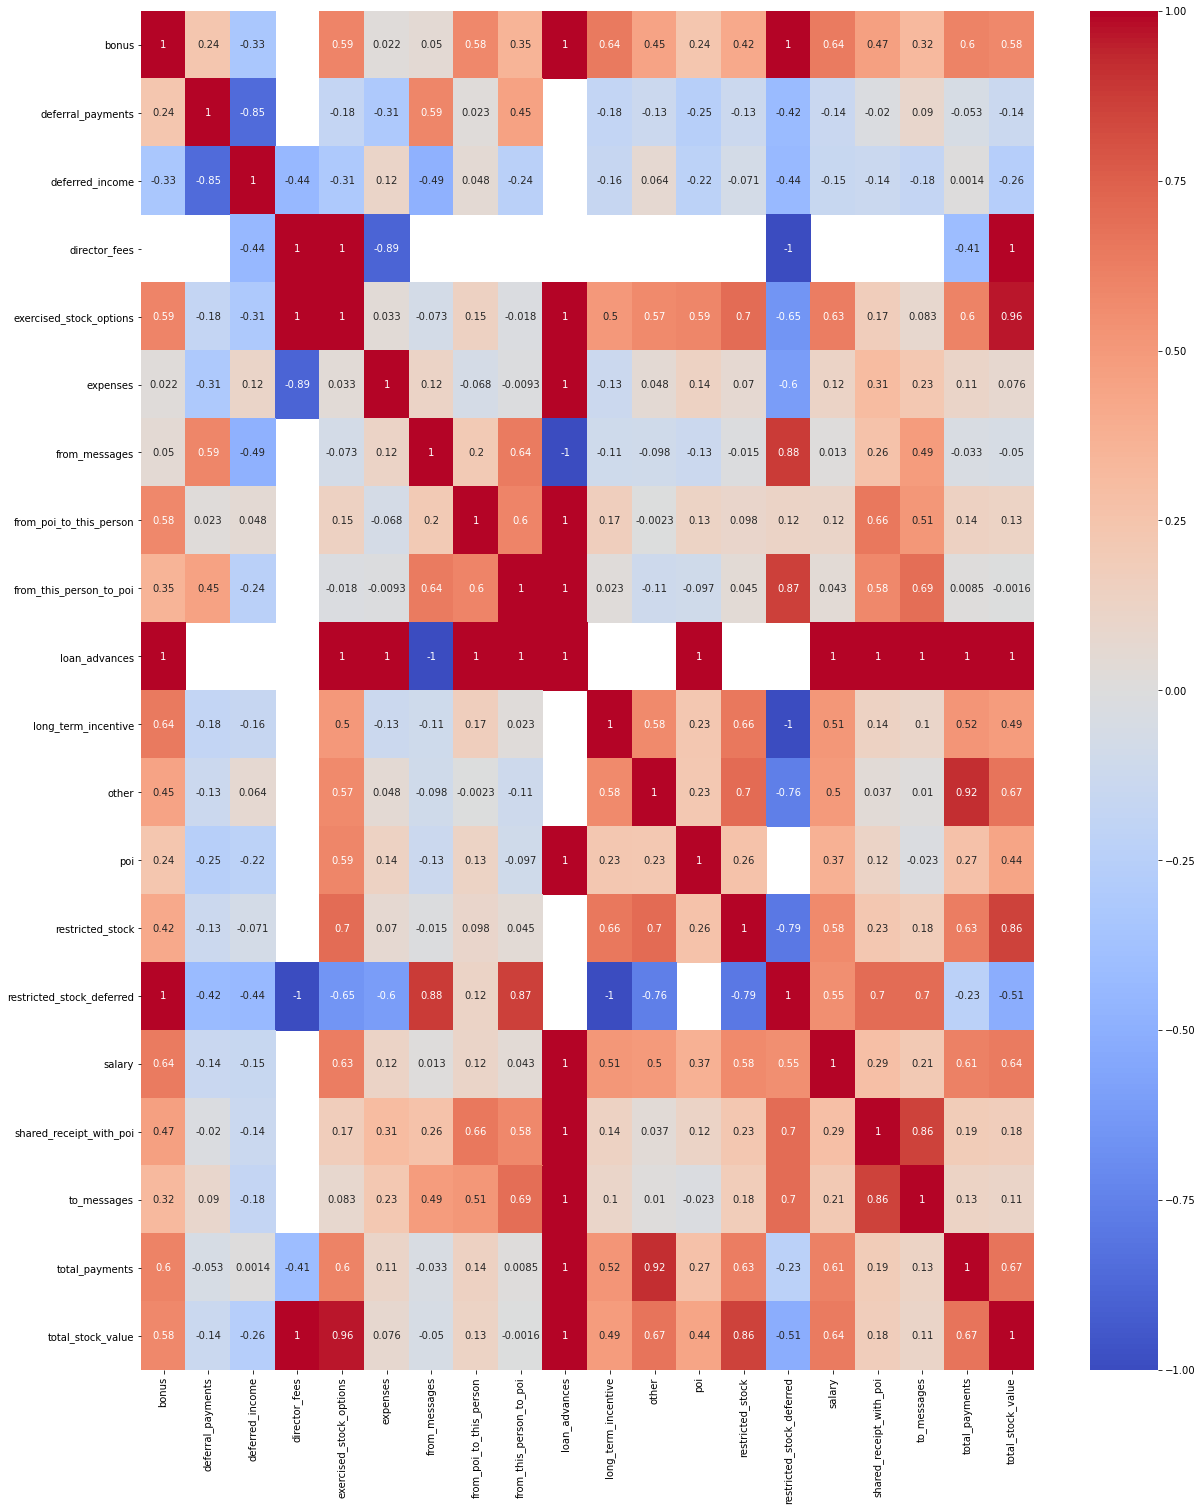

In [355]:
plt.figure(figsize=(20,25))
sns.heatmap(trainDf.corr(), cmap="coolwarm", annot=True)

In [356]:
feature_dropArray = ["loan_advances",
                     "restricted_stock_deferred",
                     "director_fees",
                     "to_messages",
                     ]

trainDf = trainDf.drop(feature_dropArray, axis=1)
testDf = testDf.drop(feature_dropArray, axis=1)

In [357]:
'''

針對 deferral_payments、deferred_income、long_term_incentive

與poi相關係數約-0.25，補中位數

先不考慮去偏，因為有些有負數。
* deferred_income 為遞延工資,打算轉成正值或考慮先MinMaxScale在去偏態。
'''

def feature_fix(data, feature_fixArray, statistic="50%"):
    
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Type of data must be pd.DataFrame.")

    if not isinstance(feature_fixArray, list):
        raise TypeError("Type of feature_fixArray must be list.")
        
    for col in feature_fixArray:
        median = data[col].describe()[statistic]
        data[col] = data[col].fillna(median)
        # data[col] = np.log10(data[col])

    return data

# default statistic=50%
feature_fixArray = ["deferral_payments", 
                    "deferred_income",
                    "long_term_incentive",
                    ]
trainDf = feature_fix(trainDf, feature_fixArray)
testDf = feature_fix(testDf, feature_fixArray)
# 先補median,後續再調整為mean
feature_fixArray = ["bonus",
                    "from_this_person_to_poi",
                    "from_poi_to_this_person",
                    "from_messages",
                    "other",
                    "exercised_stock_options",
                    "restricted_stock",
                    "total_stock_value",
                    "total_payments"
                    ]
trainDf = feature_fix(trainDf, feature_fixArray)
testDf = feature_fix(testDf, feature_fixArray)

# 
feature_fixArray = ["shared_receipt_with_poi",
                    "expenses",
                    "salary"]
trainDf = feature_fix(trainDf, feature_fixArray, statistic="mean")
testDf = feature_fix(testDf, feature_fixArray, statistic="mean")

trainDf.head()

,name,bonus,deferral_payments,deferred_income,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,poi,restricted_stock,salary,shared_receipt_with_poi,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,195190.0,-3504386.0,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,1617011.0,174839.0,True,2748364.0,420636.0,864.000000,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,195190.0,-117534.0,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,1920000.0,22122.0,True,6843672.0,1111258.0,2042.000000,8682716.0,26093672.0
2,SHELBY REX,200000.0,195190.0,-4167.0,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,422158.0,1573324.0,True,869220.0,211844.0,91.000000,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,195190.0,-117534.0,michael.kopper@enron.com,850010.0,118134.0,45.0,28.0,7.0,602671.0,907502.0,True,985032.0,224305.0,1111.369231,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,195190.0,-262500.0,christopher.calger@enron.com,850010.0,35818.0,144.0,199.0,25.0,375304.0,486.0,True,126027.0,240189.0,2188.000000,1639297.0,126027.0


In [358]:
trainDf.dtypes

name                        object
bonus                      float64
deferral_payments          float64
deferred_income            float64
email_address               object
exercised_stock_options    float64
expenses                   float64
from_messages              float64
from_poi_to_this_person    float64
from_this_person_to_poi    float64
long_term_incentive        float64
other                      float64
poi                           bool
restricted_stock           float64
salary                     float64
shared_receipt_with_poi    float64
total_payments             float64
total_stock_value          float64
dtype: object

In [359]:
nameDf, train_target = trainDf["name"], trainDf["poi"].map({True:1, False:0})
testNameDf = testDf["name"]

trainDf = trainDf.drop(["name", "poi", "email_address"], axis=1)
testDf = testDf.drop(["name", "email_address"], axis=1)

mms = MinMaxScaler()
trainDf_mms = mms.fit_transform(trainDf)
testDf_mms = mms.fit_transform(testDf)



In [360]:
# x_train, x_test, y_train, y_test = train_test_split(trainDf_mms, train_target, test_size=0.15)

# lr = LogisticRegression()
# cross_val_score(lr, x_train, y_train, scoring="accuracy")
# lr.fit(x_train, y_train)
# pred = lr.predict(x_test)
# acc = accuracy_score(y_test, pred)
# print("第一次試驗-準確率: ", acc)

In [361]:
# pred_ = lr.predict_proba(testDf_mms)
# predDf = pd.DataFrame({
#     "Name":list(testNameDf),
#     "Poi":pred_[:,1]
# })
# predDf.to_csv("./pred.csv", encoding="utf-8", index=False)

In [346]:
x_train, x_test, y_train, y_test = train_test_split(trainDf_mms, train_target, test_size=0.1)

params = {
    "n_estimators":range(10,200,5),
    "max_depth":range(3,16),
    # "max_leaf_nodes":None
}

CV, SCORING, VERBOSE, N_JOBS = 10, None, 1, 4

rfc = RandomForestClassifier()
grid = GridSearchCV(rfc, params, cv=CV, scoring=SCORING, verbose=VERBOSE, n_jobs=N_JOBS)
gridResult = grid.fit(x_train, y_train)
print("看一下隨機森林加上貪婪搜索的最佳分數: ", gridResult.best_score_)
print("隨機森林加上貪婪搜索最佳分數的參數組合為: ", gridResult.best_params_)



Fitting 10 folds for each of 494 candidates, totalling 4940 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 4940 out of 4940 | elapsed:    2.0s finished


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
rfc = RandomForestClassifier(max_depth=15, n_estimators=10)
rfc.fit(x_train, y_train)
pred = rfc.predict(x_test)
acc = accuracy_score(y_test, pred)
print("使用隨機森林後的準確度: ", acc)

In [146]:
# x_train, x_test, y_train, y_test = train_test_split(trainDf_mms, train_target, test_size=0.15)

# gbc = GradientBoostingClassifier()
# grid_ = GridSearchCV(gbc, params, cv=CV, scoring=SCORING, verbose=VERBOSE, n_jobs=N_JOBS)
# grid_Result = grid_.fit(x_train, y_train)

# print("看一下隨機森林加上貪婪搜索的最佳分數: ", grid_Result.best_score_)
# print("隨機森林加上貪婪搜索最佳分數的參數組合為: ", grid_Result.best_params_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
Fitting 10 folds for each of 247 candidates, totalling 2470 fits
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 1400 tasks      | elapsed:   15.6s
看一下隨機森林加上貪婪搜索的最佳分數:  0.8755555555555556
隨機森林加上貪婪搜索最佳分數的參數組合為:  {'max_depth': 3, 'n_estimators': 10}
[Parallel(n_jobs=4)]: Done 2470 out of 2470 | elapsed:   27.5s finished


In [147]:
# gbc = GradientBoostingClassifier(max_depth=3, n_estimators=100)
# gbc.fit(x_train, y_train)
# pred = gbc.predict(x_test)
# acc = accuracy_score(y_test, pred)
# print("使用梯度提升分類的準確度: ", acc)

使用梯度提升分類的準確度:  0.8235294117647058


In [320]:
# pred_rfc = rfc.predict_proba(testDf_mms)
# predDf = pd.DataFrame({
#     "Name":list(testNameDf),
#     "Poi":pred_[:,1]
# })
# predDf.to_csv("./pred_rfc.csv", encoding="utf-8", index=False)